In [1]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn import tree
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
import dtreeviz
from xgboost import XGBClassifier
import statistics

seed = 7112947496748021886
random.seed(seed)

In [2]:
# load full dataset
NBA_full = pd.read_csv("STAT841WorkingDataset.csv")

NBA_full.columns

Index(['Unnamed: 0', 'player_name', 'position', 'season', 'team_city',
       'team_name', 'person_id', 'height_wo_shoes', 'weight', 'wingspan',
       'standing_reach', 'standing_vertical_leap', 'max_vertical_leap',
       'lane_agility_time', 'three_quarter_sprint', 'bench_press', 'drafted',
       'Id', 'team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per',
       'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per',
       'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per',
       'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe', 'pfr', 'year',
       'pid', 'type', 'ast.tov', 'rimmade', 'rimmade.rimmiss', 'midmade',
       'midmade.midmiss', 'rimmade..rimmade.rimmiss.',
       'midmade..midmade.midmiss.', 'dunksmade', 'dunksmiss.dunksmade',
       'dunksmade..dunksmade.dunksmiss.', 'drtg', 'adrtg', 'dporpag', 'stops',
       'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb',
       'treb', 'ast', 'stl', 'blk', 'pts', 'X

In [3]:
# Take out the columns that are specifically not needed for analysis
cols_to_exclude = ["Unnamed: 0", "Id", "player_name", "season", "team_city",
                   "team", "conf", "ht", "year", "type", "team_name", "person_id",
                   "most_recent", "X", "rimmade", "rimmade.rimmiss", "midmade",
                   "midmade.midmiss", "rimmade..rimmade.rimmiss.", "midmade..midmade.midmiss.",
                   "dunksmade", "dunksmiss.dunksmade", "dunksmade..dunksmade.dunksmiss."]

# Exclude the columns
NBA_ready = NBA_full.loc[:, ~NBA_full.columns.isin(cols_to_exclude)].dropna()

In [4]:
NBA_ready_numeric = NBA_ready.select_dtypes(exclude=['object'])



In [5]:
# The order of the columns is still a little strange from previous work done on the data. We can order it properly
# for easier processing down the line.

feature_names = list(NBA_ready.columns)
feature_names.pop(feature_names.index("drafted"))

# Take out the drafted status column, and reorder the dataset to put in the front of the dataset for easy
# extraction with the columntransformer later down the line
feature_names = ["drafted"] + feature_names

NBA_ready = NBA_ready[feature_names]

# This is a simple comparison series object to ensure that we are extracting the test column
compare = NBA_ready["drafted"]

NBA_ready

,drafted,position,height_wo_shoes,weight,wingspan,standing_reach,standing_vertical_leap,max_vertical_leap,lane_agility_time,three_quarter_sprint,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,X.1
0,0,PG,72.75,191.6,74.00,94.5,29.0,32.0,10.780000,3.26,...,0.198217,5.716210,0.3143,3.3143,3.6286,4.6857,2.5429,0.0857,9.7714,2.673240
1,1,PF,79.50,220.1,83.75,105.0,32.5,39.0,10.810000,3.27,...,3.320650,3.852990,2.6842,5.2895,7.9737,1.9737,0.8947,1.0263,12.3684,2.350110
2,0,SG,76.50,209.2,80.25,100.5,28.5,34.5,11.085424,3.27,...,3.523240,3.792920,0.3846,2.1795,2.5641,1.4103,1.1026,0.1538,11.0256,11.620000
3,0,SF,76.50,209.6,82.75,103.5,29.0,35.0,11.680000,3.07,...,4.218880,3.044240,1.3929,4.2500,5.6429,3.6071,1.3214,1.2857,15.3571,5.171220
4,1,PG,71.75,187.0,79.50,97.0,25.5,33.0,10.960000,3.27,...,4.874780,0.140775,0.5152,3.1515,3.6667,5.8182,1.2727,0.2424,20.3333,9.191700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1,PG,76.50,180.9,80.25,100.0,33.5,41.5,10.420000,3.19,...,1.463490,0.535932,0.4865,2.0541,2.5405,1.7838,0.8919,0.1622,9.4324,8.061630
659,0,SG,76.50,206.4,78.00,101.0,24.0,30.0,11.600000,3.43,...,5.348800,2.414910,0.8108,3.5135,4.3243,3.1081,1.2703,0.0811,14.9189,12.839100
660,1,PF-C,81.25,246.8,86.00,105.5,33.0,38.0,10.940000,3.20,...,4.905340,1.930600,3.0938,5.5312,8.6250,0.8438,0.7188,0.8750,16.0938,0.988768
661,1,SF-SG,74.75,198.6,81.75,100.0,33.0,41.5,11.020000,3.05,...,5.563880,3.927380,2.1351,2.7568,4.8919,1.7297,1.1622,1.0270,11.2162,2.232800


In [6]:
# Since the response variable is already 0-1-encoded, we actually need to switch it back to yes/no
# Note the use of the values property, since pandas Series preserve the index, which was causing some issues
NBA_ready["drafted"] = pd.Series(np.where(NBA_ready["drafted"].values == 0, "no", "yes")).values

In [7]:
# Show the columns we will be using
NBA_ready.columns

Index(['drafted', 'position', 'height_wo_shoes', 'weight', 'wingspan',
       'standing_reach', 'standing_vertical_leap', 'max_vertical_leap',
       'lane_agility_time', 'three_quarter_sprint', 'bench_press', 'GP',
       'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per',
       'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA',
       'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr',
       'num', 'porpag', 'adjoe', 'pfr', 'pid', 'ast.tov', 'drtg', 'adrtg',
       'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm',
       'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'X.1'],
      dtype='object')

In [8]:
# Notice that drafted status has been changed to yes/no, and that the only other categorical variables
# are position played and the year of college each player played their last tournament in
NBA_ready.dtypes

drafted                    object
position                   object
height_wo_shoes           float64
weight                    float64
wingspan                  float64
standing_reach            float64
standing_vertical_leap    float64
max_vertical_leap         float64
lane_agility_time         float64
three_quarter_sprint      float64
bench_press               float64
GP                          int64
Min_per                   float64
Ortg                      float64
usg                       float64
eFG                       float64
TS_per                    float64
ORB_per                   float64
DRB_per                   float64
AST_per                   float64
TO_per                    float64
FTM                         int64
FTA                         int64
FT_per                    float64
twoPM                       int64
twoPA                       int64
twoP_per                  float64
TPM                         int64
TPA                         int64
TP_per        

In [9]:
# The position column contains primary and secondary positions, leading to much higher sparsity between
# categories. As a result, I will be categorizing based on players' primary position
NBA_ready["position"] = NBA_ready["position"].str[:2]

# Note that since centers (C) sometimes have split positions, there is a dash included in the object
NBA_ready["position"].value_counts() 

SG    166
PF    147
PG    131
SF    118
C      50
C-     11
Name: position, dtype: int64

In [10]:
# To address this, we simply take out the dashes
NBA_ready["position"] = NBA_ready["position"].replace('-', '', regex=True)

NBA_ready["position"].value_counts()

SG    166
PF    147
PG    131
SF    118
C      61
Name: position, dtype: int64

In [11]:
NBA_ready.columns

Index(['drafted', 'position', 'height_wo_shoes', 'weight', 'wingspan',
       'standing_reach', 'standing_vertical_leap', 'max_vertical_leap',
       'lane_agility_time', 'three_quarter_sprint', 'bench_press', 'GP',
       'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per',
       'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA',
       'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'yr',
       'num', 'porpag', 'adjoe', 'pfr', 'pid', 'ast.tov', 'drtg', 'adrtg',
       'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm',
       'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'X.1'],
      dtype='object')

In [12]:
# Apply a column transformer that employs one-hot encoding to categorical variables, and scaling to continuous ones
ct = ColumnTransformer([
    ('onehot',
        OneHotEncoder(drop="first"),
        make_column_selector(dtype_include=object)),
    ('scale', StandardScaler(),
        make_column_selector(dtype_include=np.number))
    ],
    verbose_feature_names_out=False)

In [13]:
# To ensure we have acceptable data, we can see that we have a good mix of both one-hot and continous,
# scaled and normalized variables
nba_trans = ct.fit_transform(NBA_ready)

ct.get_feature_names_out()

array(['drafted_yes', 'position_PF', 'position_PG', 'position_SF',
       'position_SG', 'yr_Jr', 'yr_So', 'yr_Sr', 'height_wo_shoes',
       'weight', 'wingspan', 'standing_reach', 'standing_vertical_leap',
       'max_vertical_leap', 'lane_agility_time', 'three_quarter_sprint',
       'bench_press', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per',
       'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per',
       'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per',
       'stl_per', 'ftr', 'num', 'porpag', 'adjoe', 'pfr', 'pid',
       'ast.tov', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm',
       'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb',
       'ast', 'stl', 'blk', 'pts', 'X.1'], dtype=object)

In [14]:
# To ensure that we're actually preserving the outputs we want, we can check against when we saved the responses
# from earlier
sum(nba_trans[:, 0] != compare)

0

### Bootstrap Feature Importance

In [15]:
# Since there are so many features, it may be in our best interest to perform some sort of regularization.
# First, using 10-fold CV, we will select an optimal value for either L1 or L2 regularization.

# XGBoost performs well on a small number of highly important variables. We can perform importance
# selection implied by a model trained on the entirety of a training set to derive feature importance,
# then we can perform some selection of a number of important variables, say 2-5, and with regularization

train = nba_trans[:, 1:]
test = nba_trans[:, 0]

In [18]:

# CV_XGB takes a train and a test set and conducts 5-fold CV for each pair of eta and gamma values
# (XGBoost tuning parameters). While it is not very flexible as a function, it certainly does the trick.
def CV_XGB(train, test): 
    # Using 5-fold CV since the dataset isn't very large
    n_fold = 5
    
    # Split up the dataset into calibration and test sets
    X_calib, X_test_final, y_calib, y_test_final = train_test_split(train, test, train_size = .8)
    
    cv = KFold(
        n_splits=n_fold,  # number of folds
        shuffle=True  # protects against data being ordered, e.g., all successes first
        )
    
    # Our eta and gamma values to iterate through
    eta_vals = np.arange(0.1, 0.6, 0.1)
    gamma_vals = np.arange(0.2, 1.2, 0.2)

    # A container to record our hyperparameter values and their respective cross-validation errors
    cv_errors = {}
    
    for i in range(0, len(eta_vals)):
        for j in range(0, len(gamma_vals)):
            # Set up a list container so we can calculate average test error
            cv_loss = []
            for (train_id, test_id) in cv.split(X_calib):
                # foldwise training and test data
                X_train = X_calib[train_id, 1:]
                y_train = y_calib[train_id]
                X_test = X_calib[test_id, 1:]
                y_test = y_calib[test_id]

                # Create a binary classifier XGBoost model for each combination of eta and gamma values
                cv_model = XGBClassifier(eta = i, gamma = j, objective = 'binary:logistic')
                # Train on our data
                cv_model.fit(X_train, y_train)

                cv_loss.append(1.0 - cv_model.score(X_test, y_test))

            cv_error = np.mean(cv_loss)
            # Record our average CV error for each (eta, gamma) pair
            cv_errors[(i, j)] = cv_error
            
    return(cv_errors)

In [19]:
total_cv_errors = CV_XGB(train, test)
# We can see that we that the errors are different, and have been recorded
total_cv_errors

{(0, 0): 0.6205252525252526,
 (0, 1): 0.6203838383838384,
 (0, 2): 0.6205252525252525,
 (0, 3): 0.6203636363636363,
 (0, 4): 0.6204444444444444,
 (1, 0): 0.33131313131313134,
 (1, 1): 0.3792929292929293,
 (1, 2): 0.36947474747474746,
 (1, 3): 0.35131313131313135,
 (1, 4): 0.39155555555555555,
 (2, 0): 0.3655757575757576,
 (2, 1): 0.37143434343434345,
 (2, 2): 0.3614343434343434,
 (2, 3): 0.3996363636363637,
 (2, 4): 0.4174949494949495,
 (3, 0): 0.4015959595959596,
 (3, 1): 0.5022020202020201,
 (3, 2): 0.44761616161616163,
 (3, 3): 0.4595757575757576,
 (3, 4): 0.3835151515151515,
 (4, 0): 0.445979797979798,
 (4, 1): 0.4741212121212121,
 (4, 2): 0.4900404040404041,
 (4, 3): 0.4136969696969697,
 (4, 4): 0.4659191919191919}

In [20]:
params = min(total_cv_errors, key = total_cv_errors.get)

# record our best eta and gamma values
params

(1, 0)

Now that we have cross-validated for our ideal step size shrinkage and minimum loss reduction, we can perform
nonparametric bootstrap samples to determine which of the features are the most important

Feature importance is a good indicator of whether or not a feature should be considered for an XGBoost model, since it determines how much an individual feature contributes to the 'decision' made by the XGBoost model.

In [22]:
# Conduct 1000 bootstrap samples to determine bootstrap-averaged feature importance, from which we can use our
# final 8-10 highest importance features

n_boot = 1000
n = nba_trans.shape[0]
keyList = [i for i in range(0, train.shape[1])]

feature_importance_container = []


for i in range(n_boot):
    random.seed(i)
    # Use nonparametric bootstrap to generate feature importance for each model
    boot_sample = np.random.choice(range(n), replace = True, size = n)
    
    # Conduct an XGBoost classification model using our optimal hyperparameters, and record feature importance
    # scores (particulary, total gain scores, which are the most similar to the feature importance found in random
    # forest models)
    boot_model = XGBClassifier(eta = 1, gamma = 0, objective = 'binary:logistic')
    
    boot_model.fit(train[boot_sample, :], test[boot_sample])
    
    feature_importances = boot_model.get_booster().get_score(importance_type = "total_gain")
    
    feature_importance_container += [feature_importances]

In [23]:
# Extract each feature to calculate bootstrap mean, SE, and confidence interval

# Takes the 
def extract_feature_imp(lst, index):
    return [item[index] for item in lst]

boot_importance_by_feature = []

feature_importance_container[0]

{'f0': 0.5259504914283752,
 'f3': 2.224379777908325,
 'f4': 2.723571300506592,
 'f5': 0.7016599774360657,
 'f6': 23.09351921081543,
 'f7': 18.434967041015625,
 'f8': 19.681264877319336,
 'f9': 14.504170417785645,
 'f10': 0.485105961561203,
 'f11': 42.552364349365234,
 'f12': 4.053670406341553,
 'f13': 24.0333194732666,
 'f14': 14.424583435058594,
 'f15': 1.816743016242981,
 'f16': 29.89222526550293,
 'f17': 28.48514747619629,
 'f18': 8.235798835754395,
 'f19': 14.38315200805664,
 'f20': 1.897722840309143,
 'f21': 4.2743706703186035,
 'f22': 18.13797378540039,
 'f23': 2.481764793395996,
 'f24': 0.7078239917755127,
 'f25': 12.08775806427002,
 'f26': 0.3456229567527771,
 'f27': 7.26711893081665,
 'f28': 2.3661837577819824,
 'f29': 9.355968475341797,
 'f30': 6.237644195556641,
 'f31': 10.07938003540039,
 'f32': 7.863998889923096,
 'f33': 1.2624510526657104,
 'f34': 16.727825164794922,
 'f35': 9.449917793273926,
 'f36': 1.8355551958084106,
 'f37': 5.461122035980225,
 'f38': 16.9001808166503

In [24]:
# This is a basic function that generates dictionary items in the form of lists based on the key-value pairs
# of a different dictionary
def dict_updater(dictionary, new_dict):
    for key in new_dict.keys():
        if key not in dictionary.keys():
            dictionary[key] = [new_dict[key]]
        else:
            dictionary[key] = dictionary.get(key, None) + [new_dict[key]]
    return(dictionary)

In [25]:
# Since the XGBoost models have regularization effects on each bootstrapped dataset, there are 
# potentially different subsets of the total feature space every time. Therefore, we have to 
# gather the bootstrapped feature importance by the recorded feature index
final_dict = {}

for i in range(1000):
    final_dict = dict_updater(final_dict, feature_importance_container[i])

In [31]:
final_dict['f0']

[0.5259504914283752,
 0.3335798978805542,
 0.3738403916358948,
 1.377589225769043,
 0.07487117499113083,
 11.402565956115723,
 0.4269900321960449,
 0.046638160943984985,
 3.785395383834839,
 2.975554943084717,
 1.028571367263794,
 0.33587512373924255,
 3.546210765838623,
 8.571428298950195,
 0.6220870018005371,
 0.1402672976255417,
 0.14536869525909424,
 2.4535160064697266,
 0.12104437500238419,
 0.21783509850502014,
 0.2496570348739624,
 9.64913558959961,
 0.4935193955898285,
 0.9649374485015869,
 1.5715930461883545,
 13.319684982299805,
 0.3734707832336426,
 2.4284210205078125,
 0.2968277931213379,
 0.15150374174118042,
 0.7140457630157471,
 1.028571367263794,
 7.084194183349609,
 8.855742454528809,
 0.11418592929840088,
 5.358373641967773,
 7.144331932067871,
 8.050335884094238,
 2.2128515243530273,
 1.7966480255126953,
 2.444516181945801,
 7.9432830810546875,
 4.474474906921387,
 0.3332279622554779,
 0.4375290870666504,
 0.27188870310783386,
 0.6666666269302368,
 4.5474934577941895

In [32]:
# This takes the values associated with each feature and takes bootstrap mean and SE
def extract_boot_metrics(dictionary):
    means = {}
    SE_container = {}
    for key, value in dictionary.items() :
        means[key] = sum(value) / 1000
        
        difference = np.subtract(np.asarray(dictionary[key]), np.asarray(means[key]))
        SE_container[key] = np.sqrt((1 / 999) * sum(np.square(difference)))
    return(means, SE_container)

boot_means, boot_SEs = extract_boot_metrics(final_dict)

In [33]:
# We can now sort the mean and Standard Error values by feature
sortable_means = [[int(key[1:]), value] for key, value in boot_means.items()]
sortable_SEs = [[int(key[1:]), value] for key, value in boot_SEs.items()]
sortable_means = sorted(sortable_means)
sortable_SEs = sorted(sortable_SEs)

# Simply sorting by index to make sure we can preserve the feature numbers, we put these results into a dataframe
# for analysis.
means_df = pd.DataFrame(sortable_means)
SEs_df = pd.DataFrame(sortable_SEs)
#SEs_df
means_df

,0,1
0,0,0.975917
1,1,0.448010
2,2,0.817783
3,3,1.151687
4,4,2.264457
...,...,...
58,58,4.528564
59,59,7.288277
60,60,8.539052
61,61,6.967784


In [36]:
means_df["SEs"] = SEs_df.iloc[:, 1]

# We can now sort the dataset by increasing feature importance
means_df = means_df.sort_values(by = 1)
means_df

,0,1,SEs
1,1,0.448010,1.847285
2,2,0.817783,2.070838
0,0,0.975917,2.124031
5,5,1.035069,2.443229
3,3,1.151687,2.597858
...,...,...,...
12,12,18.890914,14.641442
48,48,23.595675,22.001413
11,11,35.933441,17.253486
16,16,36.106949,27.792147


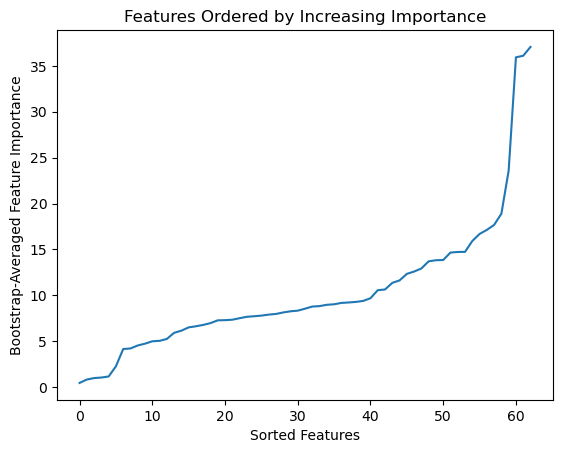

<Figure size 640x480 with 0 Axes>

In [52]:
plt.plot(range(63), means_df[1])
plt.xlabel("Sorted Features")
plt.ylabel("Bootstrap-Averaged Feature Importance")
plt.title("Features Ordered by Increasing Importance")
plt.show()
#plt.savefig("Feature_Importance.png")

We can see the there is a steep rise in feature importance for the top 5 or so features. This would suggest
that we can use a subset of the total possible predictors, and we could yield good, if not better results.

In [38]:
# We cho
feature_subset = means_df.iloc[52:63, :]

feature_subset

,0,1,SEs
14,14,14.719750,10.532248
20,20,14.730796,11.999169
13,13,15.913430,10.754404
47,47,16.684435,21.751815
34,34,17.125305,11.174492
6,6,17.670576,9.846716
12,12,18.890914,14.641442
48,48,23.595675,22.001413
11,11,35.933441,17.253486
16,16,36.106949,27.792147


In [39]:
# Use this subset model by selecting the columns for use in a final XGBoost model.
final_features = nba_trans[:, 1:]
final_test = nba_trans[:, 0]

final_features = final_features[:, np.asarray(feature_subset[0])]
#final_features.shape

In [40]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(final_features,
                                                                            final_test, train_size = .8)

In [44]:
final_XGB = XGBClassifier(eta = 1, gamma = 0, objective = 'binary:logistic')

final_XGB.fit(X_train_final, y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [45]:
print("XGBoost model test error: {}".format(
    1.0 - final_XGB.score(X=X_test_final, y=y_test_final)
))

XGBoost model test error: 0.272


We can see that by optimizing for the most important feature models, we get an error rate of 0.272, or an accuracy
score of about 73%.

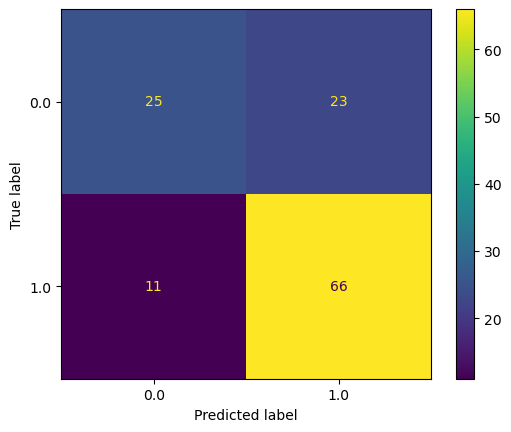

In [46]:
y_pred = final_XGB.predict(X_test_final)
cm = confusion_matrix(y_test_final, y_pred, labels=final_XGB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=final_XGB.classes_)
disp.plot()
disp.figure_.savefig('XGB_confusion.png')

Here we can see that this model is much better at predicting that a player gets drafted than if a player does not get
drafted